In [102]:
import pandas as pd
import numpy as np

In [90]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
df = pd.read_csv('torch.utilsn_historical.csv')

In [24]:
df.head()

,Date,Close
0,2008-01-02 00:00:00-02:00,0.749389
1,2008-01-03 00:00:00-02:00,0.745956
2,2008-01-04 00:00:00-02:00,0.721930
3,2008-01-07 00:00:00-02:00,0.734515
4,2008-01-08 00:00:00-02:00,0.716209


In [25]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class PriceDataset(Dataset):
    def __init__(self, dataframe, window_size):
        self.data = dataframe["Close"].values  # Pega os preços como uma matriz numpy
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        # Extrai um lote (batch) de dados e rótulos
        x = self.data[idx: idx + self.window_size]  # Sequência de preço
        y = self.data[idx + self.window_size]  # Próximo preço como rótulo
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [76]:
def create_dataset(data, window_size, batch_size):
    dataset = PriceDataset(data, window_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

In [77]:
n = int(0.85*len(df))

train_dataset = df[:n]
test_dataset = df[n:]

In [78]:
window_size = 5
batch_size = 16

In [79]:
train = create_dataset(train_dataset, window_size=window_size, batch_size=batch_size)
test = create_dataset(test_dataset, window_size=window_size, batch_size=batch_size)

In [107]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    stock = stock.drop(columns='Date')
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 5 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3112, 4, 1)
y_train.shape =  (3112, 1)
x_test.shape =  (778, 4, 1)
y_test.shape =  (778, 1)


In [111]:
y_train.size(),x_train.size()

(torch.Size([3112, 1]), torch.Size([3112, 4, 1]))

In [109]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [110]:
x_train

tensor([[[0.7494],
         [0.7460],
         [0.7219],
         [0.7345]],

        [[0.7460],
         [0.7219],
         [0.7345],
         [0.7162]],

        [[0.7219],
         [0.7345],
         [0.7162],
         [0.7036]],

        ...,

        [[3.5140],
         [3.6178],
         [3.5572],
         [3.5745]],

        [[3.6178],
         [3.5572],
         [3.5745],
         [3.6697]],

        [[3.5572],
         [3.5745],
         [3.6697],
         [3.5918]]])

In [96]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        # Number of hidden layers
        self.num_layers = num_layers
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [97]:
model

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [98]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [130]:
# Train model
#####################
num_epochs = 10000
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.00418021809309721
Epoch  20 MSE:  0.0036318788770586252
Epoch  30 MSE:  0.003194403136149049
Epoch  40 MSE:  0.002848077332600951
Epoch  50 MSE:  0.0025808103382587433
Epoch  60 MSE:  0.0023806786630302668
Epoch  70 MSE:  0.002238222397863865
Epoch  80 MSE:  0.0021418475080281496
Epoch  90 MSE:  0.0020796176977455616
Epoch  100 MSE:  0.0020401414949446917
Epoch  110 MSE:  0.0020140514243394136
Epoch  120 MSE:  0.0019947399850934744
Epoch  130 MSE:  0.0019782227464020252
Epoch  140 MSE:  0.0019624666310846806
Epoch  150 MSE:  0.0019466049270704389
Epoch  160 MSE:  0.0019303506705909967
Epoch  170 MSE:  0.0019136440241709352
Epoch  180 MSE:  0.0018964922055602074
Epoch  190 MSE:  0.0018789148889482021
Epoch  200 MSE:  0.0018609307007864118
Epoch  210 MSE:  0.0018425637390464544
Epoch  220 MSE:  0.0018238439224660397
Epoch  230 MSE:  0.0018048062920570374
Epoch  240 MSE:  0.00178549624979496
Epoch  250 MSE:  0.0017659645527601242
Epoch  260 MSE:  0.0017462694086134434
Ep

In [113]:
import matplotlib.pyplot as plt

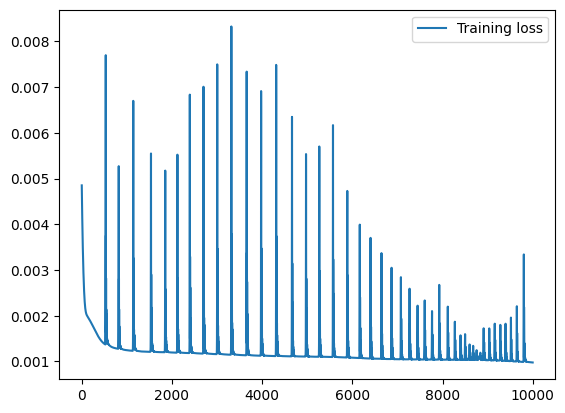

In [131]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [119]:
import math
from sklearn.metrics import mean_squared_error

In [121]:
# make predictions
y_test_pred = model(x_test)

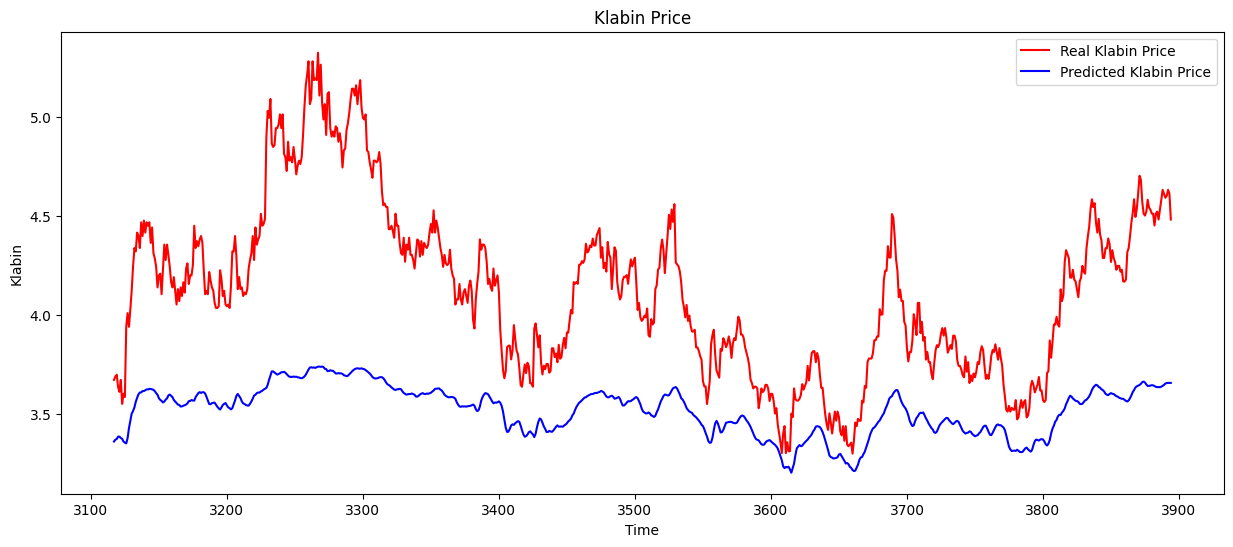

In [132]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
# axes.xaxis_date()

axes.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'Real Klabin Price')
axes.plot(df[len(df)-len(y_test):].index, y_test_pred.detach().numpy(), color = 'blue', label = 'Predicted Klabin Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Klabin Price')
plt.xlabel('Time')
plt.ylabel('Klabin')
plt.legend()
plt.show()